# An introduction to transmission spectroscopy with SPIRou


The goal of this tutorial is to provide to the user simple ingredients to carry out transmission spectroscopy with SPIRou. Based on a publicly available standard sequence of 100 exposures of the M1 dwarf Gl514 (ID: 19AE99, PI: Claire Moutou) obtained with SPIRou on 2019/05/14, this notebook tackles one by one all the steps needed to carry out the search for an hypothetical planet signature within the sequence. It is associated with a tutorial document explaining the main steps of this practical work (see "tutorial_transmission.pdf"). Please, refer to this document for further explanations.

This notebook is organised as follows:
0. Read the data sets
> This tutorial is associated with a set of 60 exposures (stored in Data/ directory, 60/100 exposures selected for time purpose) downloaded from the Canadian Astronomy Data Centre (CADC, http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/). We select the data reduced by the SPIRou data reduction software (DRS), without correction for tellurics (*e.fits files, cf http://www.cfht.hawaii.edu/Instruments/SPIRou/SPIRou_pipeline.php for the various type of data). For each exposure, we read the AB combined wavelength, flux and blaze function within each order, divide the flux by the Blaze function. From the header of the fits, we read the date (BJD), airmass, barycentric Earth radial velocity (berv) and Signal to Noise Ratio (SNR). Finally, the stellar radial velocity measured from the DRS is read in the associated 'v.fits' file (Drift corrected value, key: CCFRVC). All these information are stored in the '.dat' files located in the 'Data/.' repository. In this tutorial, we work only with the  ***diffraction order 47** (1608-1658 nm) as it hosts strong H2O absorption lines without being drowned into telluric absorption bands.<br>
> No transiting planet has be detected around Gl514. Using the simple template of water absorption spectrum described in Section 2, we generate a synthetic signature inspired from HD189733b transit (containing water only). The parameters used to generate this transit are detailed below in Section 0. We added the synthetic planet signature to the exposures stored in 'Data/' and stored the resulting exposures in the directory 'Planet/'.

1. Data reduction process (removal of stellar and telluric spectra and normalisation)
> 1.1 - Removal of the median spectrum and normalisation of each spectrum <br>
> 1.2 - Removal of the residuals of tellurics (detrending with airmass) <br>
> 1.3 - Rejection of outliers and bad pixels <br>
> 1.4 - Removal of the remaing correlated noise using principal component analysis (PCA)

2. Synthesis of a template planet spectrum
> Using a dedicated method described in Section 2, we generated a few very simple models of water absorption spectra for the planet (for time purpose). The goal of this part is to create a model a water absorption signature for the planet given an input transit-curve.

3. Retrieve the planet signature
> The goal of this section is to combine the signal within all the water absorption lines resolved at SPIRou resolving power to unveil the planet signature within the data. A simplified post-analysis process is proposed  in this tutorial while references are provided to the user if he wants to go further.




## 0 - Read the data

As described in the introduction above, 60 exposures reduced by the SPIRou DRS were selected from the publicly available spectroscopic sequence of Gl514 (2019 May 14). The Blaze-corrected exposures are available in the directory **Data/** and stored in the format <br>
date[BJD] \n berv[km/s] \n rv_s[km/s] \n snr[DRS] \n airmass \n  Wavelength[nm] Itensity[Blaze-corrected]

In this preliminary Section, we create an Object 'Observations', implemented in **'data_red.py'**, that contain all the methods and attribute to conduct the data reduction (see Section 1).

#### 0.1. Read raw data sets
The exposures in 'Data/' do not contain any planet signatures.

In [1]:
from data_red import *

rep_data = "Data"    ### Repository where data are stored

### Read the blaze-corrected exposures
lim_outlier = 2.0    #Limit above which the point is not read
name_obs = "Gl514"   #Name of the sequence

### Create object to make data reduction
OBS = Observations(name_obs) 

planet = False  ### if true, store exposures in a dedicated attribute of the class Observations
                ### In the case without planet -> exposures stored in Observation.I_raw

### Read data
OBS.read_data(rep_data,lim_outlier,planet)

### Plot airmass, snr and shift to move to the stellar rest frame for all the exposures
OBS.plot_infos()

Read data
Read data - no planet
DONE


<Figure size 640x480 with 3 Axes>

#### 0.2. Read data sets with planet signature

The exposures in 'Planet/' are obtained by generating a synthetic planet signature using the method described below and by using the properties of the planet orbit to move this signature with time. The planet properties, inspired from HD189733b, are described in the Table below, where we assumed a circular orbit for the planet. Assuming an isothermal homogeneous atmosphere for the synthetic planet, we use use the petitRADTRANS python module (Molliere et al. 2019, A&A, 627A, 67M), that carries out a line-by-line resolution of the radiative transfer equation for all water absorption lines in HITEMP2010 database (Rothman et al. 2010, J. Quant. Spec. Radiat. Transf., 111, 2139) at the equilibrium temparature of the planet (see the Figures in the associated pdf document). For exoplanet modelling, please note that many useful tools can be found in this NASA website: https://emac.gsfc.nasa.gov/. Using the the simple equation $V_{\rm{r}}(t) = K_{\rm{p}} \sin \left( \frac{2\pi}{P_{\rm{orb}}} (t - T_{0}) \right) + V_{0}$, where $V_{0} = 0$ km/s, we shift the resulting transmission spectrum in the planet rest frame. Finally, we multiply the resulting synthetic sequence by an inversed transit window (maximum signal at mid-transit), obtained using the batman python module (https://www.cfa.harvard.edu/~lkreidberg/batman/) assuming a non-linear limb-darkening model with coefficients from Hayek et al. 2012 (A&A, 539A, 102H).


We add the planet signature to the reduced exposures (i.e. in Data/ directory) and store the resulting spectra in the directory 'Planet/'. When read using the Observations.read_data method, indicate planet = True and the exposures with the planet signatures will be stores in the attribute Observations.I_raw_pl. In what follows, we the index '_pl' denotes the data set where a planet signature is injected, while the index '_nopl' stands for the raw sequence, without planet.





| Planet properties                      | Value             |
|----------------------------------------|-------------------|
|Radius (R$_{\rm{p}}$)                   |0.157 R$_{\rm[S}$  |
|Mass (M$_{\rm{p}}$)                     |1.142 M$_{\rm{J}}$ |
|Transit inclination ($i$)               |85.710 deg         |
|Orbital period (P$_{\rm{orb}}$)         |2.218 d            |
|semi-major-axis ($a$)                   |8.863 R$_{\rm[S}$  |
|Mid-transit time (T$_{0}$)              |2458617.87046 [BJD]|
|Semi-amplitude (K$_{\rm{p}}$)           |154.5 km/s         |
|Equilibrium temperature (T$_{\rm{eq}}$) |1100 K             |
|Composition atmosphere                  |H2, He, H20        |
|Volume mixing ratio (VMR, H2O)          |0.001              |



In [2]:
### Read data with signature from synthetic planet

planet     = True     ### -> exposures stored in Observation.I_raw_pl
rep_planet = "Planet" ### Directory of the exposures + synthetic planet signature

OBS.read_data(rep_planet,lim_outlier,planet)

Read data
Read data with signature of synthetic planet
DONE


#### 0.3. Plot sequence of spectra

Use the global function 'plot_2D' to display the sequence of spectra

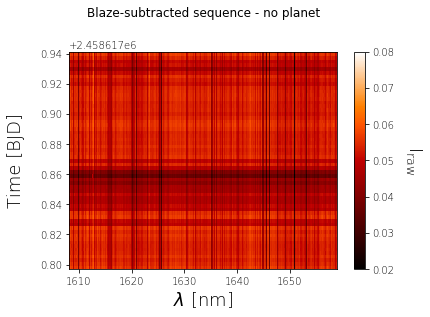

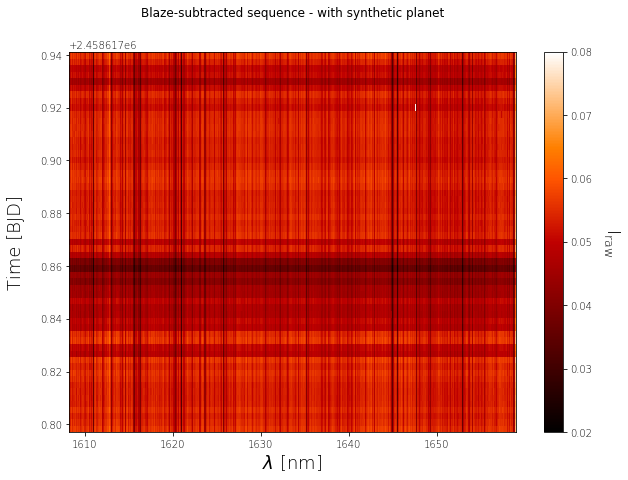

In [3]:
### Plot the dynamical spectrum of the order

### Limits of the x and y axes
x_lim = [np.min(OBS.W_raw),np.max(OBS.W_raw)] #Limits of wavelength axis
y_lim = [np.min(OBS.date),np.max(OBS.date)]   #Limits of time axis (or orbital phase)
LIM   = [x_lim,y_lim]

z_inf,z_sup = 0.02,0.08  #Inf and Sup imits of the colormap

### Labels of the map
x_lab = r"$\lambda$ [nm]"     #Wavelength axis
y_lab = r"Time [BJD]"         #Time axis
z_lab = r"I$_{\rm{raw}}$"     #Intensity (exposures)
LAB   = [x_lab,y_lab,z_lab]

### Titles of the plots
title_nopl = "Blaze-subtracted sequence - no planet"              #No planet
title_pl   = "Blaze-subtracted sequence - with synthetic planet"  #Synthetic planet signature added

### Plot -- same **kwargs as matplotlib fct pcolor
plot_2d(OBS.W_raw,OBS.date,OBS.I_raw,LIM,LAB,title_nopl,vmin=z_inf,vmax=z_sup,cmap="gist_heat")
plot_2d(OBS.W_raw,OBS.date,OBS.I_raw_pl,LIM,LAB,title_pl,vmin=z_inf,vmax=z_sup,cmap="gist_heat")


## 1 - Data reduction


#### 1.1. Subtract median spectrum

The first step consists in removing the median spectrum along the time axis. This will remove most of the stellar spectrum and a significant part of the tellurics. Note that this is done on the geocentric frame as the tellurics will be aligned. The stellar spectrum moves by ~500 m/s and will leave residuals that will be corrected in further steps of the data reduction process (another method is to model the stellar spectrum and to shift it in the geocentric frame). 

**Use the method Observations.subtract_median() to compute the median spectrum along the time axis and then divide each exposure by the median spectrum.**

**Note:** We propose to compute the median spectrum on all the available exposures (including during transit) as (i) a larger number of used exposures considerably lower the noise in the median spectrum and (ii) the planet spectrum is expected to be poorly impacted by this computation as it is shifted by ~20 km/s during the sequence. However, it is still possible to compute the median on the out-of-transit spectra only by adding to the method Observations.subtract_median 2 arguments: ind_ini and ind_out, which stand respectively for the indices of the beginning and end of the transit event (here ind_ini = 15, ind_end = 46).

In [4]:
### Compute median stellar spectrum, I_med, and divide each exposure by I_med
I_med_nopl, I_sub_nopl = OBS.subtract_median(OBS.I_raw)     ### On data set without planet
I_med_pl, I_sub_pl     = OBS.subtract_median(OBS.I_raw_pl)  ### On data set with synthetic planet signature


### Uncomment the following 3 lines to compute median on out-of-transit spectra only
#ind_ini,ind_end        = 15,46
#I_med_nopl, I_sub_nopl = OBS.subtract_median(OBS.I_raw,ind_ini,ind_end)     ### On data set without planet
#I_med_pl, I_sub_pl     = OBS.subtract_median(OBS.I_raw_pl,ind_ini,ind_end)  ### On data set with synthetic planet signature

In [5]:
### Uncomment the following lines to compare the 2 median spectra

#plt.plot(OBS.W_raw,I_med_pl,alpha=0.7)
#plt.plot(OBS.W_raw,I_med_pl,"--")
#plt.xlabel(r"$\lambda$ [nm]")
#plt.ylabel(r"I$_{\rm{med}}$")
#plt.show()


#### 1.2. Normalize residual spectra

It is crucial to normalize the median-subracted spectra without adding unwanted features that could mask the planet signature and create false positives. We propose 2 methods for normalizing the spectra: (i) make an iterative low-order polynomial fit with outlier removal at each iteration to each residual exposure, then divide the corresponding exposure by the best model; (ii) for each exposure, compute a 'continuum' spectra by applying a moving median to each residual exposure, then divide each exposure by the continuum spectrum. Method (ii) is more adaptable and can be seen as a low-pass filter, where the length of the window to compute the moving median controls the range of frequencies (in wavelength space) including in the continuum spectrum. This option is useful to some diffraction orders exhibiting significant low frequencies structures.

We recommand the user to use the moving median solution for the order considered here (47). The user has to option to plot one by one all the normalized spectra (with the best fit to the continuum), but it may take a bit of time. If the user has some time left, they is invited to try the normalization with polynomial fit.

**Note:** For case (ii), the size of the moving window is determined by 'N_best' (half of the nb of pts used to compute the median). To tune this parameter, we make N_best varies and compute the standard deviation of the resulting normalized spectrum. We then select the largest value such that the standard deviation of the normalized spectra is roughly flat. The parameter N_bor is the number of points removed at each edge of each exposure to avoid edge effects. If N_best > N_bor, the moving average is computing on smaller amount of points until N_best pts are available on both sides.

In [6]:
plot_nopl = False   ### Uncomment to display all the normalized exposures
plot_pl   = False   ### Uncomment to display all the normalized exposures

N_best = 100   ### N_best: half width of the moving window (in term of nb of pts - see note above)
N_bor  = 50    ### N_bor:  number of points removed at each edge of each exposure (see note above)

### Normalize each spectrum using a moving median (case (ii))
### Generally takes a bit time - but not enough to drink a coffee (I think)
I_norm_nopl, W2 = OBS.norm_mav(OBS.W_raw,I_sub_nopl,N_best,N_bor,plot_nopl) #no planet injected
I_norm_pl, W2 = OBS.norm_mav(OBS.W_raw,I_sub_pl,N_best,N_bor,plot_pl)   #synthetic planet injected



### Uncomment the following lines to normalize using low-order polynomial fit

#sig_clip = 5.0 #sig_clip: pts deviating from more than 'sig_clip' sigmas to the model are removed
#I_norm_nopl = OBS.norm_pol(OBS.W_raw,I_sub_nopl,plot=plot_nopl,sig_clip)  #no planet
#I_norm_pl   = OBS.norm_pol(OBS.W_raw,I_sub_pl,plot=plot_pl,sig_clip)    #synthetic planet

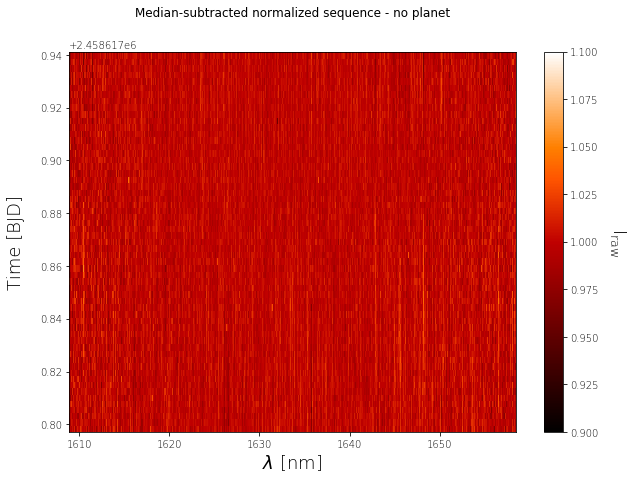

In [7]:
### Uncomment the following lines to planet the sequence of normalized spectra on a 2D map

### Limits of the axes
x_lim = [np.min(W2),np.max(W2)]
y_lim = [np.min(OBS.date),np.max(OBS.date)]
LIM   = [x_lim,y_lim]

z_inf,z_sup = 0.9,1.1  ### color bar

### Labels on the axes (z = colorbar)
x_lab = r"$\lambda$ [nm]"
y_lab = r"Time [BJD]"
z_lab = r"I$_{\rm{raw}}$"
LAB   = [x_lab,y_lab,z_lab]

###### Without planet
title_nopl = "Median-subtracted normalized sequence - no planet"
plot_2d(W2,OBS.date,I_norm_nopl,LIM,LAB,title_nopl,vmin=z_inf,vmax=z_sup,cmap="gist_heat")

###### With planet
#title_pl = "Median-subtracted normalized sequence - with synthetic planet"
#plot_2d(W2,OBS.date,I_norm_pl,LIM,LAB,title_pl,vmin=z_inf,vmax=z_sup,cmap="gist_heat")



#### 1.3. Detrending with airmass

Clear time-dependent residuals are visible in the sequence on normalized spectra, due to residual tellurics non corrected at step 1.1. It is quite common in the litterature to detrend the sequence of normalized spectra with the airmass (e.g. Brogi et al. 2016, APJ 817, 106B). The method Observations.detrend_airmass() models the airmass-dependent component, namely $I_{\rm{c}}$, by $I_{\rm{c}}(t) = I_{0} + I_{1} \times A(t) +  I_{2} \times A(t)^{2}$, where A(t) is the airmass at time t, and $I_{0}$, $I_{1}$ and $I_{2}$ are the constant, linear and quadratic spectra to be removed from the normalized sequence. Observations.detrend_airmass() uses a least-square estimator (LSE) estimate these parameters and subtract the airmass-dependent component from the normalized sequence.

**Note:**  Brogi et al. 2018 (A&A, 615A, 16B) recommends to detrend with airmass in log space. We thus let this as an option in the method Observations.detrend_airmass().

In [8]:
### Detrending with airmass

deg       = 2     # Degree of the model of airmass (must remain low in order not to eliminate planet signature)
log_space = False # if True, model fitted in log space
plot      = False  # if True, plot the airmass-dependent components removed with the process

I_m_nopl = OBS.detrend_airmass(W2,I_norm_nopl,deg,log_space,plot)  ### No planet injected
I_m_pl   = OBS.detrend_airmass(W2,I_norm_pl,deg,log_space,plot)    ### With synthetic planet



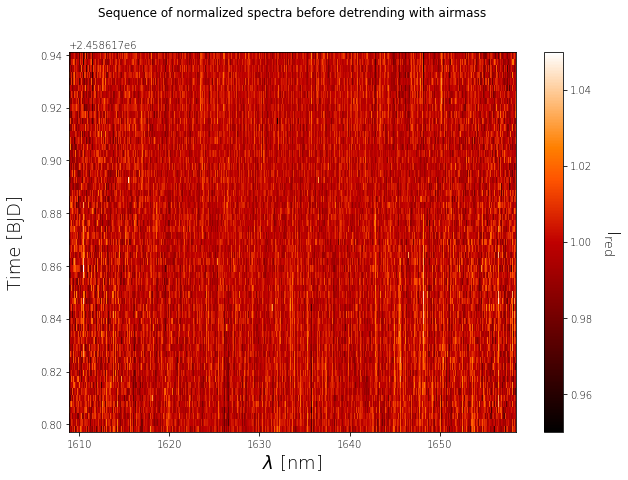

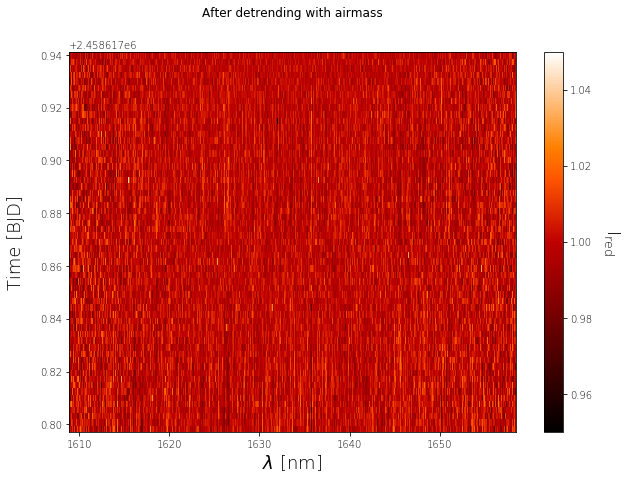

In [9]:
### Uncomment the following lines to planet the sequence of spectra before and after detrending with airmass

### Limits of the axes
x_lim = [np.min(W2),np.max(W2)]
y_lim = [np.min(OBS.date),np.max(OBS.date)]
LIM   = [x_lim,y_lim]

z_inf,z_sup = 0.95,1.05  ### color bar

# Labels on the axes (z = colorbar)
x_lab = r"$\lambda$ [nm]"
y_lab = r"Time [BJD]"
z_lab = r"I$_{\rm{red}}$"
LAB   = [x_lab,y_lab,z_lab]

###### Before detrending with airmass
title_1 = "Sequence of normalized spectra before detrending with airmass"
plot_2d(W2,OBS.date,I_norm_nopl,LIM,LAB,title_1,vmin=z_inf,vmax=z_sup,cmap="gist_heat")

###### After detrending with airmass
title_2= "After detrending with airmass"
plot_2d(W2,OBS.date,I_m_nopl,LIM,LAB,title_2,vmin=z_inf,vmax=z_sup,cmap="gist_heat")


#### 1.4. Remove outliers

As a first step, we compute the standard deviation of each pixel along the time axis (method Observations.pix_std_distrib). The remaining sequence of spectra should be dominated by a noise of the same order of the noise measured by the SPIRou DRS. We expect the edges of the order to be more polluted by noise than the center of the ordre. As a result, we carry out an iterative polynomial fit with outlier removal on the distribution of the standard deviations of the pixels. All the pixels whose standard deviation is rejected through the polynomial fit are removed from the sequence of spectra. 

After this step, we can visualize if the standard deviation within each spectrum is consistent with the SNR provided by the SPIRou DRS. To do so, we apply method Observations.spec_std_distrib to estimate the SNR at the center of each spectrum and to compare it with the SNR provided by the DRS. In this case, we note that the standard deviation within the reduced sequence of spectra is significantly stronger than the noise provided by the DRS, due to residuals of tellurics non-removed by step 1.3 and visible when plotting the sequence of spectra in a 2D map.



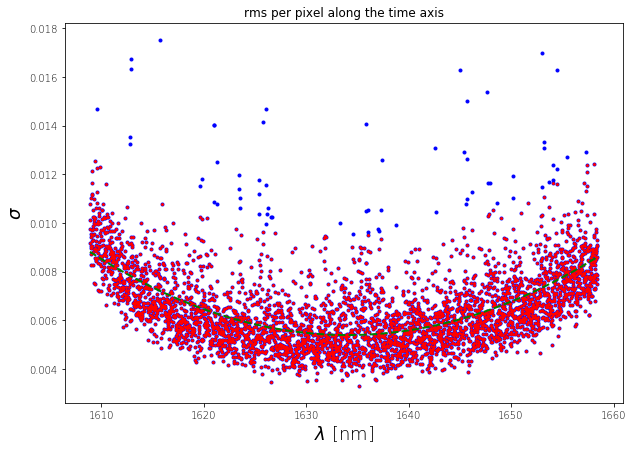

Median STD DRS: 0.0037065615839924687
Median STD reduced sequence: 0.005359651234461688


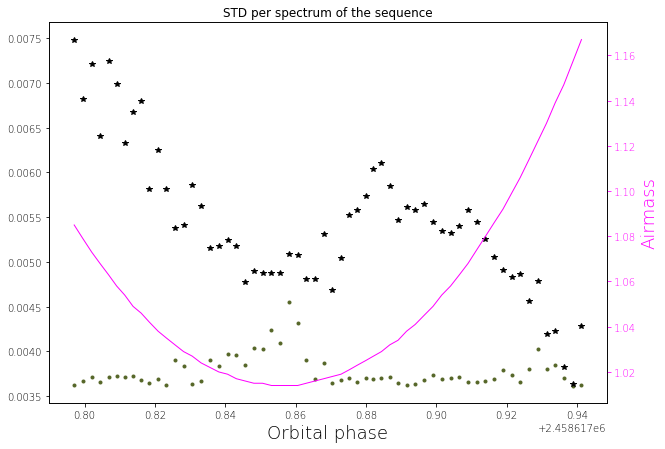

In [10]:
### Compute the standard deviation of each pixel along the time axis
### Make 2nd order polynomial fit and remove pixels deviating for more than sig_clip sigma from the fit

deg       = 2     #Degree of the polynomial fit
sig_clip  = 4.0   #Threshold above which outleirs are removed
n_iter    = 4     #Number of iterations of the polynomial fit
plot_nopl = True  #Plot the distribution of standard dev. and best fit - no planet
plot_pl   = False #Plot the distribution of standard dev. and best fit - with planet

W_filt_nopl,I_filt_nopl = OBS.px_std_distrib(W2,I_m_nopl,sig_clip,deg,n_iter,plot_nopl) #no planet
W_filt_pl,I_filt_pl     = OBS.px_std_distrib(W2,I_m_pl,sig_clip,deg,n_iter,plot_pl)     #with planet


### Plot distribution of SNR for all spectra in the sequence and compare it with values provided by DRS

N_mid    = 400 #Half width of the centered window used to compute the SNR (I[id_mid-N_mid:id_mid+N_mid]
               #where id_mid is the index of the center wavelength)
sig_clip = 4.0 #Compute the SNR by doing a sig_clip-sigma clipping

OBS.spec_std_distrib(W_filt_nopl,I_filt_nopl,N_mid,sig_clip)
#OBS.spec_std_distrib(W_filt_pl,I_filt_pl,N_mid,sig_clip)   #With planet - similar to previous case

#### 1.5. Re-apply all the steps

Once bad pixels are removed from the sequence of spectra, we propose to apply all the steps above (subtract median, normalization, detrending with airmass and outlier removal), but this time, by normalizing the residual spectra using a polynomial fit rather than a moving median, as the low-frequency structures has already been corrected.


Median STD DRS: 0.0037065615839924687
Median STD reduced sequence: 0.005348335483047074


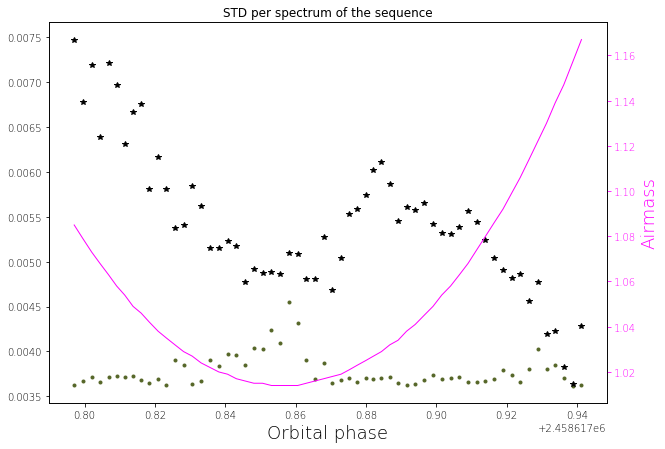

In [11]:
### Compute and divide each spectrum by the median spectrum
### Enter 'ind_ini,ind_end' as an argument of the fct to compute on out-of-transit spectra
I_med_nopl2, I_sub_nopl2 = OBS.subtract_median(I_filt_nopl)  ### On data set without planet
I_med_pl2, I_sub_pl2     = OBS.subtract_median(I_filt_pl)    ### On data set with synthetic planet signature


### Normalize spectra using a polynomial fit
plot_pol_nopl = False
plot_pol_pl = False
I_norm_nopl_2 = OBS.norm_pol(W_filt_nopl,I_sub_nopl2,plot=False)
I_norm_pl_2   = OBS.norm_pol(W_filt_pl,I_sub_pl2,plot=False)


### Detrend with airmass
deg        = 2     # Degree of the model of airmass (must remain low in order not to eliminate planet signature)
log_space  = False # if True, model fitted in log space
plot       = False  # if True, plot the airmass-dependent components removed with the process
I_m_nopl_2 = OBS.detrend_airmass(W_filt_nopl,I_norm_nopl_2,deg,log_space,plot)  ### No planet injected
I_m_pl_2   = OBS.detrend_airmass(W_filt_pl,I_norm_pl_2,deg,log_space,plot)      ### With synthetic planet


### Reject bad pixels
deg       = 2      #Degree of the polynomial fit
sig_clip  = 4.0    #Threshold above which outleirs are removed
n_iter    = 4      #Number of iterations of the polynomial fit
plot_nopl = False  #Plot the distribution of standard dev. and best fit - no planet
plot_pl   = False  #Plot the distribution of standard dev. and best fit - with planet
W_filt_nopl_2,I_filt_nopl_2 = OBS.px_std_distrib(W_filt_nopl,I_m_nopl_2,sig_clip,deg,n_iter,plot_nopl) #no planet
W_filt_pl_2,I_filt_pl_2     = OBS.px_std_distrib(W_filt_pl,I_m_pl_2,sig_clip,deg,n_iter,plot_pl)       #with planet


### Plot distribution of the standard deviation within spectra of the sequence
N_mid    = 400 #Half width of the centered window used to compute the SNR (I[id_mid-N_mid:id_mid+N_mid]
sig_clip = 4.0 #Compute the SNR by doing a sig_clip-sigma clipping
OBS.spec_std_distrib(W_filt_nopl_2,I_filt_nopl_2,N_mid,sig_clip)
#OBS.spec_std_distrib(W_filt_pl_2,I_filt_pl_2,N_mid,sig_clip)   #With planet - similar to previous case




#### 1.6. Remove correlated residuals with PCA

We assume (and it is the case here) that the variance within the reduced sequence of spectra is dominated by the noise (actually dominated by residuals of tellurics). By applying principal component analysis to sequence of reduced spectra, we can build a new sequence where the components that contribute the most to the variance within the sequence are removed. The number of components to remove is such that the remaining spectra have a standard deviations roughly compatible with those provided by SNR. **Note:** A more adapted way to do that would be to create realistic noise maps and by remove components until the associated is roughly equal to that of the maximum eigen values of the noise maps. Also, one may have a look to how the explained variance, i.e. the ratio between the variance of a principal component and the total variance, varies with the considered component. For time purpose, here we only select the number such that the standard deviation of each spectrum is more or less consistent with the value provided from the DRS.

**By applying PCA to the reduced sequence of spectra, find the number of components that lead to a distribution of standard deviations similar to that provided by the DRS**


In [ ]:
N_comp = 3   ### Number of components removed using PCA (remove the N_comp component with the largest eigenvalue)

### I_pca_nopl: Reduced sequence of spectra obtained by removing N_comp components with PCA
### I_del_nopl: list of all components removed with PCA (each component is a 2D array)
### e_val_nopl: Vector of the eigenvalues of the covariance matrix
I_pca_nopl,I_del_nopl,e_val_nopl = make_pca(N_comp,I_filt_nopl_2) # Case no planet
I_pca_pl,I_del_pl,e_val_pl = make_pca(N_comp,I_filt_pl_2)         # Case with planet



### Uncomment the two lines below to plot the sequence of spectra cleaned with PCA

## No planet
title_nopl = "PCA - " + str(N_comp) + " components removed - no planet"
plot_2d(W_filt_nopl_2,OBS.date,I_pca_nopl,LIM,LAB,title_nopl,vmin=-0.05,vmax=0.05,cmap="gist_heat")

## With planet
title_pl = "PCA - " + str(N_comp) + " components removed - with planet"
plot_2d(W_filt_pl_2,OBS.date,I_pca_pl,LIM,LAB,title_pl,vmin=-0.05,vmax=0.05,cmap="gist_heat")

### Uncomment to plot each component removed using PCA - no planet
#c = 1
#for idel in I_del_nopl:
#    title = "PCA - Component " + str(c) + " - no planet"
#    plot_2d(W_filt_nopl_2,OBS.date,idel,LIM,LAB,title,vmin=-0.05,vmax=0.05,cmap="gist_heat")
#    c += 1

### Uncomment to plot each component removed using PCA - no planet
#c = 1
#for idel in I_del_pl:
#    title = "PCA - Component " + str(c) + " with planet"
#    plot_2d(W_filt_pl_2,OBS.date,idel,LIM,LAB,title,vmin=-0.05,vmax=0.05,cmap="gist_heat")
#    c += 1 
    
    
### Plot the standard deviation of each spectrum cleaned with PCA
N_mid    = 400 #Half width of the centered window used to compute the SNR (I[id_mid-N_mid:id_mid+N_mid]
sig_clip = 4.0 #Compute the SNR by doing a sig_clip-sigma clipping
print("Without planet")
OBS.spec_std_distrib(W_filt_nopl_2,I_pca_nopl,N_mid,sig_clip)

print("With planet")
OBS.spec_std_distrib(W_filt_pl_2,I_pca_pl,N_mid,sig_clip)

